In [212]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Load the data

In [2]:
df = pd.read_csv('./data/2019_opens_clean.csv')
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [3]:
cols = ['competitorid','gender','age','height','weight','overallrank','is_scaled', \
        'scaled_1','scaled_2','scaled_3','scaled_4','scaled_5', \
        'time_2','time_3','time_4','time_5', \
        'bs_backsquat','bs_cleanandjerk','bs_snatch','bs_deadlift', 'bs_fightgonebad', \
        'bs_maxpull_ups', 'bs_fran','bs_grace','bs_helen', 'bs_filthy50','bs_sprint400m', \
        'bs_run5k','w1_reps_total','w2_reps_total','w2_reps_t2b','w2_reps_du','w2_reps_sqcl', \
        'w2_rounds_completed','w2_tiebreak', 'w3_reps_total','w3_hspu_status','w3_tiebreak', \
        'w4_reps_total','w4_reps_bmu','w4_bmu_status','w4_tiebreak','w5_reps_total']

In [4]:
df = df[cols]

### Quick look at data structure

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338538 entries, 0 to 338537
Data columns (total 43 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   competitorid         338538 non-null  int64  
 1   gender               338538 non-null  object 
 2   age                  338534 non-null  float64
 3   height               180986 non-null  float64
 4   weight               192160 non-null  float64
 5   overallrank          338538 non-null  int64  
 6   is_scaled            338538 non-null  int64  
 7   scaled_1             338538 non-null  int64  
 8   scaled_2             338538 non-null  int64  
 9   scaled_3             338538 non-null  int64  
 10  scaled_4             338538 non-null  int64  
 11  scaled_5             338538 non-null  int64  
 12  time_2               302615 non-null  float64
 13  time_3               292251 non-null  float64
 14  time_4               280276 non-null  float64
 15  time_5           

In [6]:
# dataframe without benchmarks or height & weight
scores_cols = ['competitorid', 'gender', 'age', 'overallrank', 'is_scaled', \
               'scaled_1', 'scaled_2', 'scaled_3', 'scaled_4', 'scaled_5', \
               'time_2','time_3','time_4','time_5', \
               'w1_reps_total', 'w2_reps_total', 'w2_reps_t2b', 'w2_reps_du', \
               'w2_reps_sqcl', 'w2_rounds_completed', 'w2_tiebreak', 'w3_reps_total', \
               'w3_hspu_status', 'w3_tiebreak', 'w4_reps_total', 'w4_reps_bmu', \
               'w4_bmu_status', 'w4_tiebreak', 'w5_reps_total']
df_scores = df[scores_cols]
# dataframe with height & weight
hw_cols = ['height', 'weight', 'overallrank']
df_hw = df[hw_cols]
# dataframe with with benchmarks
bs_cols = ['overallrank', 'bs_backsquat', 'bs_cleanandjerk', 'bs_snatch', 'bs_deadlift', \
           'bs_fightgonebad', 'bs_maxpull_ups', 'bs_fran', 'bs_grace', 'bs_helen', \
           'bs_filthy50', 'bs_sprint400m', 'bs_run5k']
df_bs = df[bs_cols]

### Data Cleaning

#### Scores Dataframe

In [29]:
df_scores.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 219491 entries, 0 to 338398
Data columns (total 29 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   competitorid         219491 non-null  int64  
 1   gender               219491 non-null  int64  
 2   age                  219491 non-null  float64
 3   overallrank          219491 non-null  int64  
 4   is_scaled            219491 non-null  int64  
 5   scaled_1             219491 non-null  int64  
 6   scaled_2             219491 non-null  int64  
 7   scaled_3             219491 non-null  int64  
 8   scaled_4             219491 non-null  int64  
 9   scaled_5             219491 non-null  int64  
 10  time_2               219436 non-null  float64
 11  time_3               219489 non-null  float64
 12  time_4               219464 non-null  float64
 13  time_5               219491 non-null  float64
 14  w1_reps_total        219491 non-null  float64
 15  w2_reps_total    

In [32]:
df_scores.shape

(219407, 29)

In [31]:
# drop rows with missing age values
df_scores = df_scores[df_scores['age'].notna()]
# keep just rows with all 5 workouts participated
df_scores = df_scores[df_scores['w1_reps_total'].notna()]
df_scores = df_scores[df_scores['w2_reps_total'].notna()]
df_scores = df_scores[df_scores['w3_reps_total'].notna()]
df_scores = df_scores[df_scores['w4_reps_total'].notna()]
df_scores = df_scores[df_scores['w5_reps_total'].notna()]
# drop rows with missing time values
df_scores = df_scores[df_scores['time_2'].notna()]
df_scores = df_scores[df_scores['time_3'].notna()]
df_scores = df_scores[df_scores['time_4'].notna()]
df_scores = df_scores[df_scores['time_5'].notna()]

In [33]:
# set missing tiebreak values to zero
df_scores['w2_tiebreak'].replace(np.NaN,0,inplace=True)
df_scores['w3_tiebreak'].replace(np.NaN,0,inplace=True)
df_scores['w4_tiebreak'].replace(np.NaN,0,inplace=True)

In [34]:
# replace categorical values with integer 1/0
df_scores['gender'].replace(['M','F'],[1,0],inplace=True)
df_scores['w3_hspu_status'].replace([1.0,0.0],[1,0],inplace=True)
df_scores['w4_bmu_status'].replace([1.0,0.0],[1,0],inplace=True)

In [35]:
df_scores.shape

(219407, 29)

#### Heights&Weights Dataframe

In [36]:
df_hw.shape

(173135, 3)

In [37]:
df_hw = df_hw.dropna()

In [38]:
df_hw.shape

(173135, 3)

#### Benchmark Dataframe

In [39]:
df_bs.shape

(2067, 13)

In [40]:
df_bs = df_bs.dropna()

In [41]:
df_bs.shape

(2067, 13)

### Create Test Sets

In [42]:
train_set_sc, test_set_sc = train_test_split(df_scores, test_size=0.3, random_state=42)
train_set_hw, test_set_hw = train_test_split(df_hw, test_size=0.3, random_state=42)
train_set_bs, test_set_bs = train_test_split(df_bs, test_size=0.3, random_state=42)

### Looking at correlations

In [43]:
corr_matrix_sc = train_set_sc.corr()
corr_matrix_sc['overallrank'].sort_values(ascending=False)

overallrank            1.000000
scaled_2               0.573746
scaled_4               0.544067
scaled_5               0.537383
scaled_3               0.526104
w3_tiebreak            0.521726
competitorid           0.422018
scaled_1               0.420738
is_scaled              0.402913
w4_tiebreak            0.365851
gender                 0.179956
time_3                 0.044834
age                    0.041459
time_4                 0.024954
time_2                 0.019516
time_5                 0.012619
w2_reps_sqcl          -0.026451
w2_rounds_completed   -0.028457
w2_reps_t2b           -0.030240
w2_reps_total         -0.030924
w2_reps_du            -0.031688
w2_tiebreak           -0.045819
w4_bmu_status         -0.171023
w5_reps_total         -0.178179
w4_reps_total         -0.246123
w4_reps_bmu           -0.246409
w3_hspu_status        -0.406268
w3_reps_total         -0.499977
w1_reps_total         -0.524824
Name: overallrank, dtype: float64

In [44]:
corr_matrix_hw = train_set_hw.corr()
corr_matrix_hw['overallrank'].sort_values(ascending=False)

overallrank    1.000000
weight         0.206267
height         0.167184
Name: overallrank, dtype: float64

In [45]:
corr_matrix_bs = train_set_bs.corr()
corr_matrix_bs['overallrank'].sort_values(ascending=False)

overallrank        1.000000
bs_fran            0.482549
bs_helen           0.387525
bs_filthy50        0.366112
bs_grace           0.351305
bs_run5k           0.244740
bs_sprint400m      0.195070
bs_deadlift       -0.070626
bs_backsquat      -0.120233
bs_cleanandjerk   -0.208112
bs_snatch         -0.252759
bs_maxpull_ups    -0.350511
bs_fightgonebad   -0.391688
Name: overallrank, dtype: float64

### Define Target and Features

In [46]:
y_sc = df_scores['overallrank']
X_sc = df_scores.drop(axis=1,columns='overallrank')

y_hw = df_hw['overallrank']
X_hw = df_hw.drop(axis=1,columns='overallrank')

y_bs = df_bs['overallrank']
X_bs = df_bs.drop(axis=1,columns='overallrank')

In [47]:
X_train_sc, X_test_sc, y_train_sc, y_test_sc = train_test_split(X_sc, y_sc, random_state=42)
X_train_hw, X_test_hw, y_train_hw, y_test_hw = train_test_split(X_hw, y_hw, random_state=42)
X_train_bs, X_test_bs, y_train_bs, y_test_bs = train_test_split(X_bs, y_bs, random_state=42)

### Linear Regression Models

In [100]:
lin_reg = LinearRegression()

In [101]:
lin_reg.fit(X_train_sc, y_train_sc)
y_pred_sc = lin_reg.predict(X_test_sc)

In [149]:
lin_mse = mean_squared_error(y_test_sc,y_pred_sc)
lin_rmse = np.sqrt(lin_mse)
print(round((int(lin_rmse)/185550)*100,1),
      '% of error in overall ranking. Absolute rank error:', int(lin_rmse))

1.9 % of error in overall ranking. Absolute rank error: 3502


In [171]:
lin_reg.fit(X_train_hw, y_train_hw)
y_pred_hw = lin_reg.predict(X_test_hw)

In [172]:
lin_mse = mean_squared_error(y_test_hw,y_pred_hw)
lin_rmse = np.sqrt(lin_mse)
print(round((int(lin_rmse)/185550)*100,1),
      '% of error in overall ranking. Absolute rank error:', int(lin_rmse))

26.65481 % of error in overall ranking. Absolute rank error: 49458


In [53]:
lin_reg.fit(X_train_bs, y_train_bs)
y_pred_bs = lin_reg.predict(X_test_bs)

In [147]:
lin_mse = mean_squared_error(y_test_bs,y_pred_bs)
lin_rmse = np.sqrt(lin_mse)
print(round((int(lin_rmse)/185550)*100,1),
      '% of error in overall ranking. Absolute rank error:', int(lin_rmse))

18.3 % of error in overall ranking. Absolute rank error: 34028


### Decision Tree Regression Models

In [184]:
tree_reg = DecisionTreeRegressor()

In [185]:
scale_cols = ['competitorid','gender','age','time_2','time_3', \
              'time_4', 'time_5', 'w1_reps_total', 'w2_reps_total', 'w2_reps_t2b', \
              'w2_reps_du', 'w2_reps_sqcl', 'w2_rounds_completed', 'w2_tiebreak', \
              'w3_reps_total', 'w3_tiebreak', 'w4_reps_total', 'w4_reps_bmu', \
              'w4_tiebreak', 'w5_reps_total'
             ]

In [186]:
scaler = StandardScaler()

X_train_scaled_sc = scaler.fit_transform(X_train_sc[scale_cols])
X_test_scaled_sc = scaler.transform(X_test_sc[scale_cols])

X_train_scaled_hw = scaler.fit_transform(X_train_hw)
X_test_scaled_hw = scaler.transform(X_test_hw)

X_train_scaled_bs = scaler.fit_transform(X_train_bs)
X_test_scaled_bs = scaler.transform(X_test_bs)

In [187]:
# Concatenating scaled and dummy columns 
X_train_preprocessed_sc = np.concatenate([X_train_scaled_sc, X_train_sc.drop(scale_cols, axis=1)], axis=1)
X_test_preprocessed_sc = np.concatenate([X_test_scaled_sc, X_test_sc.drop(scale_cols, axis=1)], axis=1)

In [188]:
tree_reg.fit(X_train_preprocessed_sc, y_train_sc)
y_pred_sc = tree_reg.predict(X_test_preprocessed_sc)

In [189]:
lin_mse = mean_squared_error(y_test_sc,y_pred_sc)
lin_rmse = np.sqrt(lin_mse)
print(round((int(lin_rmse)/185550)*100,1),
      '% of error in overall ranking. Absolute rank error:', int(lin_rmse))

1.9 % of error in overall ranking. Absolute rank error: 3545


In [190]:
tree_reg.fit(X_train_scaled_hw, y_train_hw)
y_pred_hw = tree_reg.predict(X_test_scaled_hw)

In [191]:
lin_mse = mean_squared_error(y_test_hw,y_pred_hw)
lin_rmse = np.sqrt(lin_mse)
print(round((int(lin_rmse)/185550)*100,1),
      '% of error in overall ranking. Absolute rank error:', int(lin_rmse))

26.7 % of error in overall ranking. Absolute rank error: 49566


In [192]:
tree_reg.fit(X_train_scaled_bs, y_train_bs)
y_pred_bs = tree_reg.predict(X_test_scaled_bs)

In [193]:
lin_mse = mean_squared_error(y_test_bs,y_pred_bs)
lin_rmse = np.sqrt(lin_mse)
print(round((int(lin_rmse)/185550)*100,1),
      '% of error in overall ranking. Absolute rank error:', int(lin_rmse))

26.9 % of error in overall ranking. Absolute rank error: 49892


In [264]:
scores = cross_val_score(tree_reg, X_train_scaled_hw, y_train_hw, cv=5, n_jobs=-1)

In [265]:
print('Score:', round(scores.mean(), 4))

Score: 0.0298


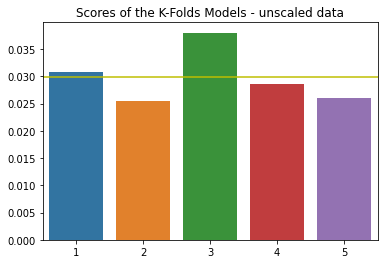

In [266]:
plt.axhline(y=scores.mean(), color='y', linestyle='-')
sns.barplot(x=[1,2,3,4, 5],y=scores).set_title('Scores of the K-Folds Models - unscaled data');

### Hyperparameter Tuning

In [210]:
tree_reg.get_params().keys()

dict_keys(['ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'random_state', 'splitter'])

In [290]:
# Defining parameter grid (as dictionary)
param_grid = {"max_depth" : [10,15,20],
              "max_features" : [1,2,3],
              "max_leaf_nodes" : [80,100,120],
              "min_impurity_decrease" : [0.05],
              #"min_impurity_split" : [],
              #"min_samples_leaf" : [],
              #"min_samples_split" : [],
              #"min_weight_fraction_leaf" : [],
             }

# Instantiate gridsearch and define the metric to optimize 
gs = GridSearchCV(tree_reg, param_grid, cv=5, verbose=5, n_jobs=-1)

In [291]:
gs.fit(X_train_scaled_hw, y_train_hw)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


/Users/juliusjenek/Documents/neuefische/project-crossfit-data/.venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.06438409 0.06593296 0.06628377 0.06954836 0.06932804 0.06923208
        nan        nan        nan 0.0649146  0.06650196 0.06343183
 0.07035996 0.07068484 0.07066946        nan        nan        nan
 0.06281694 0.06841554 0.06871124 0.07035996 0.07065591 0.07063349
        nan        nan        nan]
  warnings.warn(


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [10, 15, 20], 'max_features': [1, 2, 3],
                         'max_leaf_nodes': [80, 100, 120],
                         'min_impurity_decrease': [0.05]},
             verbose=5)

In [292]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",gs.best_estimator_)
print("\n The best score across ALL searched params:\n",gs.best_score_)
print("\n The best parameters across ALL searched params:\n",gs.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:
 DecisionTreeRegressor(max_depth=15, max_features=2, max_leaf_nodes=100,
                      min_impurity_decrease=0.05)

 The best score across ALL searched params:
 0.07068483975775461

 The best parameters across ALL searched params:
 {'max_depth': 15, 'max_features': 2, 'max_leaf_nodes': 100, 'min_impurity_decrease': 0.05}
